# Analyze Cell Count

Author: Jess Ewald

In [1]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf
from tqdm import tqdm

from importlib import reload
import displayImages as di
reload(di)

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
pm_dir = "/dgx1nas1/storage/data/jess/varchamp/platemaps"

# concatenate all platemaps
pms = ["B7A1R1_P1.txt", "B7A1R1_P2.txt", "B7A1R1_P3.txt", "B7A1R1_P4.txt", "B7A2R1_P1.txt", "B8A1R2_P1.txt", "B8A1R2_P2.txt", "B8A1R2_P3.txt", "B8A1R2_P4.txt", "B8A2R2_P1.txt"]

pm_dfs = []
for pm in pms:
    try:
        temp = pl.read_csv(f"{pm_dir}/{pm}", separator="\t").select(['plate_map_name', 'well_position', 'control_type', 'gene_allele'])
        pm_dfs.append(temp)
    except Exception as e:
        print("Error reading {pm}: {e}")
    
pm_df = pl.concat(pm_dfs)

In [3]:
# Get cell count per well
cc = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet")
cc = cc.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).collect()
cc = cc.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc = cc.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc8 = pl.scan_parquet("/dgx1nas1/storage/data/sam/codes/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_02_06_Batch_8/profiles.parquet")
cc8 = cc8.select(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).collect()
cc8 = cc8.group_by(['Metadata_well_position', 'Metadata_Plate', 'Metadata_gene_allele']).agg(pl.count().alias("Cell_count"))
cc8 = cc8.with_columns(pl.col("Metadata_Plate").str.slice(11, 22).alias("Metadata_Plate"))

cc = pl.concat([cc, cc8])

In [6]:
# Add extra annotations
cc_reg = cc.with_columns(
    pl.col("Metadata_Plate").str.replace("_.*", "").alias("Platemap"),
    pl.col("Metadata_gene_allele").str.replace("_.*", "").alias("Gene_symbol"),
    pl.when(pl.col("Metadata_gene_allele").str.contains("_")).then(pl.lit("VAR")).otherwise(pl.lit("WT")).alias("Type")
)
variants = cc_reg.filter(pl.col("Type") == "VAR").select("Metadata_gene_allele").to_series().unique().to_list()
genes = cc_reg.select("Gene_symbol").to_series().unique().to_list()

In [7]:
print(len(variants))
print(len(genes))

1029
367


In [5]:
cc_res = []
for variant in tqdm(variants):
    # get data for variant
    gene_symb = variant.split("_")[0]
    
    # ensure that only wt-var pairs on same plate are included
    var_cc = cc_reg.filter(pl.col("Metadata_gene_allele") == variant)
    var_plates = var_cc.select("Metadata_Plate").to_series().unique().to_list()
    wt_cc = cc_reg.filter((pl.col("Metadata_gene_allele") == gene_symb) &
                          (pl.col("Metadata_Plate").is_in(var_plates)))
    wt_plates = wt_cc.select("Metadata_Plate").to_series().unique().to_list()
    var_cc = var_cc.filter(pl.col("Metadata_Plate").is_in(wt_plates))
    
    var_cc = pl.concat([var_cc, wt_cc])
    
    try:
        # perform stat test
        model = smf.mixedlm("Cell_count ~ Type", data=var_cc.to_pandas(), groups=var_cc.to_pandas()["Metadata_Plate"])
        result = model.fit()
        
        # format results
        summary_df = pl.DataFrame(result.summary().tables[1][1:2])
        summary_df = summary_df.with_columns(
            [pl.col(column).cast(pl.Float64).alias(column) for column in summary_df.columns]
        )
        summary_df = summary_df.with_columns(
            pl.lit(variant).alias("Variant"),
            pl.lit(gene_symb).alias("Gene")
        )
        
        # append results
        cc_res.append(summary_df)
    except Exception as e:
        print(f"An error occurred with variant {variant}: {str(e)}")

cc_res = pl.concat(cc_res)

  7%|▋         | 71/1029 [00:08<01:13, 13.04it/s]

An error occurred with variant TMEM43_Arg28Trp: negative dimensions are not allowed
An error occurred with variant TMEM43_Arg299Thr: negative dimensions are not allowed


 32%|███▏      | 333/1029 [00:33<00:57, 12.16it/s]

An error occurred with variant BLMH_Ile443Val: negative dimensions are not allowed


 49%|████▉     | 503/1029 [00:53<00:51, 10.18it/s]

An error occurred with variant TMEM43_Arg312Trp: negative dimensions are not allowed


 60%|█████▉    | 616/1029 [01:04<00:36, 11.33it/s]

An error occurred with variant TMEM43_Tyr371His: negative dimensions are not allowed


 79%|███████▊  | 810/1029 [01:25<00:34,  6.26it/s]

An error occurred with variant TMEM43_Arg220Cys: negative dimensions are not allowed


 94%|█████████▍| 966/1029 [01:43<00:06,  9.03it/s]

An error occurred with variant TMEM43_Thr277Ser: negative dimensions are not allowed


 97%|█████████▋| 1003/1029 [01:47<00:02,  9.12it/s]

An error occurred with variant TMEM43_Glu85Lys: negative dimensions are not allowed


100%|█████████▉| 1026/1029 [01:49<00:00, 11.99it/s]

An error occurred with variant TMEM43_Ala366Thr: negative dimensions are not allowed


100%|██████████| 1029/1029 [01:49<00:00,  9.36it/s]


In [7]:
def calculate_p_value(z):
    # Calculate the two-tailed p-value
    return 2 * (1 - stats.norm.cdf(abs(z)))

cc_res = cc_res.with_columns(
    pl.col("z").apply(calculate_p_value).alias("p_value")
)

# muliple hypothesis corrections
p_values = cc_res["p_value"].to_numpy()
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
cc_res = cc_res.with_columns(pl.Series("fdr", pvals_corrected))

In [10]:
print(cc_res.shape)
print(cc_res.filter(pl.col("fdr") < 0.05).shape)
print(cc_res.filter(pl.col("z") > 0).shape)

(1020, 10)
(495, 10)
(530, 10)


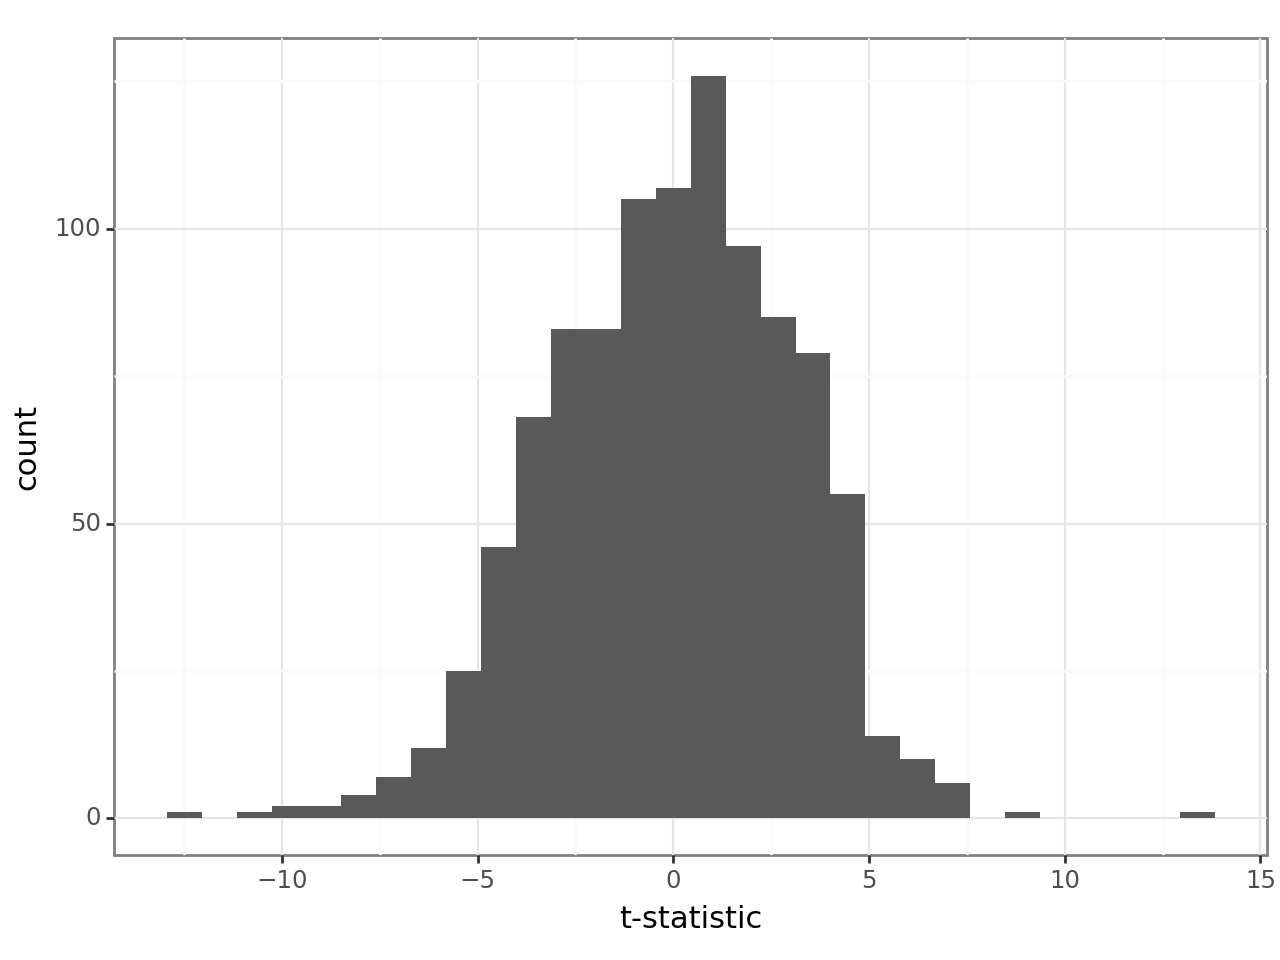

In [9]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab

plot1 = (ggplot(cc_res) 
+ aes(x = "z")
+ geom_histogram()
+ theme_bw()
+ xlab("t-statistic"))

print(plot1)

In [33]:
cc_reg.filter(pl.col("Metadata_gene_allele").is_in(["GALE_Asp103Gly", "GALE"])).sort(["Metadata_gene_allele", "Platemap"])

Metadata_well_position,Metadata_Plate,Metadata_gene_allele,Cell_count,Platemap,Gene_symbol,Type
str,str,str,u32,str,str,str
"""E09""","""B7A1R1_P2T1""","""GALE""",159,"""B7A1R1""","""GALE""","""WT"""
"""E09""","""B7A1R1_P2T4""","""GALE""",82,"""B7A1R1""","""GALE""","""WT"""
"""E09""","""B7A1R1_P2T2""","""GALE""",210,"""B7A1R1""","""GALE""","""WT"""
"""E09""","""B7A1R1_P2T3""","""GALE""",166,"""B7A1R1""","""GALE""","""WT"""
"""E09""","""B8A1R2_P2T4""","""GALE""",85,"""B8A1R2""","""GALE""","""WT"""
"""E09""","""B8A1R2_P2T1""","""GALE""",126,"""B8A1R2""","""GALE""","""WT"""
"""E09""","""B8A1R2_P2T2""","""GALE""",118,"""B8A1R2""","""GALE""","""WT"""
"""E09""","""B8A1R2_P2T3""","""GALE""",115,"""B8A1R2""","""GALE""","""WT"""
"""K09""","""B7A1R1_P2T4""","""GALE_Asp103Gly…",44,"""B7A1R1""","""GALE""","""VAR"""
